In [1]:
# 0) Imports & Setup
# ===============================
import warnings, os, sys, math
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from typing import List, Tuple

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# For VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# For pretty Markdown outputs in Jupyter
from IPython.display import Markdown, display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [8]:
# 1) Data Loading (robust path & aliases)
# ===============================
# >>>> EDIT THIS if your path is different
# Windows example (escape backslashes or use raw string):
DATA_PATH = r"C:\Users\user\Data-Science-main\ToyotaCorolla - MLR.csv"

# Fallback: if running on Linux/mac, also try local file
if not os.path.exists(DATA_PATH):
    # if a file named similarly exists in current dir, use it
    for candidate in Path(".").glob("ToyotaCorolla*"):
        DATA_PATH = str(candidate)
        break

def read_csv_with_encodings(path: str, encodings=("utf-8", "cp1252", "latin1")) -> pd.DataFrame:
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, encoding=enc)
        except Exception as e:
            last_err = e
    raise last_err

df_raw = read_csv_with_encodings(DATA_PATH)
df = df_raw.copy()

# Standardize column names
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace("-", "_", regex=False)
    .str.replace(" ", "_", regex=False)
)

# Map of canonical names to possible aliases in common Corolla datasets
ALIASES = {
    "price": ["price", "price_€", "price_eur", "price_in_euros", "price_in_eur"],
    "age": ["age", "age_08_04", "age_in_years"],
    "km": ["km", "kilometers", "kilometres", "odometer"],
    "fueltype": ["fueltype", "fuel_type", "fuel", "fuel-types"],
    "hp": ["hp", "horsepower", "horse_power"],
    "automatic": ["automatic", "automatic_binary", "is_automatic", "auto"],
    "cc": ["cc", "cylinder_volume"],
    "doors": ["doors", "nr_of_doors", "no_of_doors"],
    "weight": ["weight", "weight_kg"],
    "quarterly_tax": ["quarterly_tax", "quarterly_tax_€", "quarterly_tax_eur"],
}

def resolve_column(df, keys):
    for k in keys:
        if k in df.columns:
            return k
    return None

resolved = {}
for canon, options in ALIASES.items():
    col = resolve_column(df, options)
    if col is None:
        # not strictly fatal; some datasets may miss a field (e.g., Automatic)
        # but for Price it's required
        if canon == "price":
            raise ValueError("Price column not found. Please check your CSV column names.")
    resolved[canon] = col

# Basic cleaning
if resolved["fueltype"] and df[resolved["fueltype"]].dtype == object:
    df[resolved["fueltype"]] = (
        df[resolved["fueltype"]]
        .astype(str)
        .str.strip()
        .str.lower()
        .replace({"diesel": "diesel", "petrol": "petrol", "cng": "cng", "gas": "cng"})
    )

# Automatic: convert yes/no or string to 0/1 if needed
if resolved["automatic"] and df[resolved["automatic"]].dtype == object:
    df[resolved["automatic"]] = (
        df[resolved["automatic"]]
        .astype(str).str.strip().str.lower().replace({"yes": 1, "no": 0, "y": 1, "n": 0, "true": 1, "false": 0})
    )

# Keep a working subset with canonical names
keep_map = {k: v for k, v in resolved.items() if v is not None}
df_work = df.rename(columns={v: k for k, v in keep_map.items() if v is not None}).copy()

# Ensure numeric for numeric fields (coerce errors)
for num_col in ["price", "age", "km", "hp", "automatic", "cc", "doors", "weight", "quarterly_tax"]:
    if num_col in df_work.columns:
        df_work[num_col] = pd.to_numeric(df_work[num_col], errors="coerce")

# Drop rows with missing price or price <= 0
df_work = df_work.dropna(subset=["price"])
df_work = df_work[df_work["price"] > 0]
df

,price,age_08_04,km,fuel_type,hp,automatic,cc,doors,cylinders,gears,weight
0,13500,23,46986,diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,diesel,90,0,2000,3,4,5,1170
...,...,...,...,...,...,...,...,...,...,...,...
1431,7500,69,20544,petrol,86,0,1300,3,4,5,1025
1432,10845,72,19000,petrol,86,0,1300,3,4,5,1015
1433,8500,71,17016,petrol,86,0,1300,3,4,5,1015
1434,7250,70,16916,petrol,86,0,1300,3,4,5,1015


Shape after cleaning: (1436, 11)

Preview:


,price,age,km,fueltype,hp,automatic,cc,doors,cylinders,gears,weight
0,13500,23,46986,diesel,90,0,2000,3,4,5,1165
1,13750,23,72937,diesel,90,0,2000,3,4,5,1165
2,13950,24,41711,diesel,90,0,2000,3,4,5,1165
3,14950,26,48000,diesel,90,0,2000,3,4,5,1165
4,13750,30,38500,diesel,90,0,2000,3,4,5,1170



Describe (numeric):


,count,mean,std,min,25%,50%,75%,max
price,1436.0,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.00,32500.0
age,1436.0,55.947075,18.599988,1.0,44.0,61.0,70.00,80.0
km,1436.0,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
hp,1436.0,101.502089,14.981080,69.0,90.0,110.0,110.00,192.0
automatic,1436.0,0.055710,0.229441,0.0,0.0,0.0,0.00,1.0
cc,1436.0,1576.855850,424.386770,1300.0,1400.0,1600.0,1600.00,16000.0
doors,1436.0,4.033426,0.952677,2.0,3.0,4.0,5.00,5.0
cylinders,1436.0,4.000000,0.000000,4.0,4.0,4.0,4.00,4.0
gears,1436.0,5.026462,0.188510,3.0,5.0,5.0,5.00,6.0
weight,1436.0,1072.459610,52.641120,1000.0,1040.0,1070.0,1085.00,1615.0



Fuel Type counts:


fueltype
petrol    1264
diesel     155
cng         17
Name: count, dtype: int64

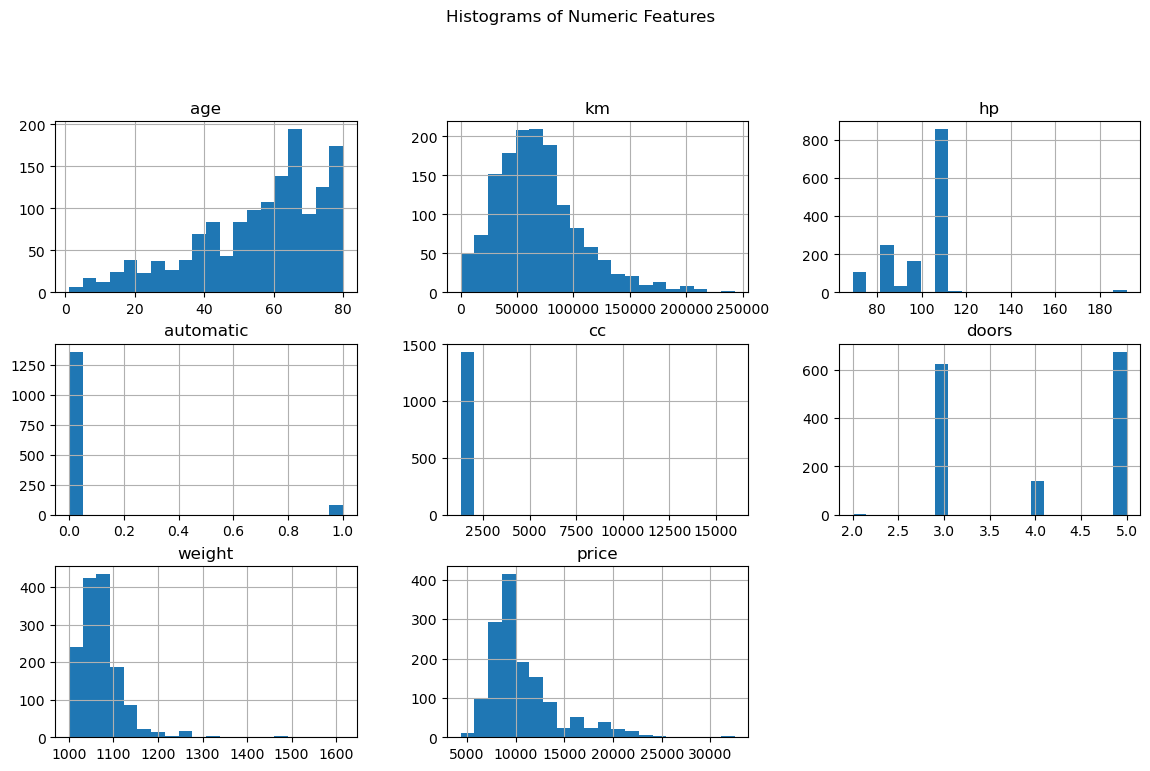

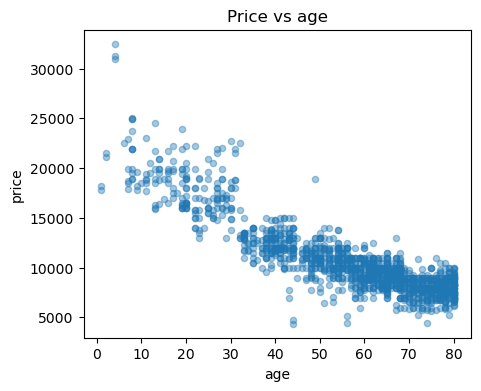

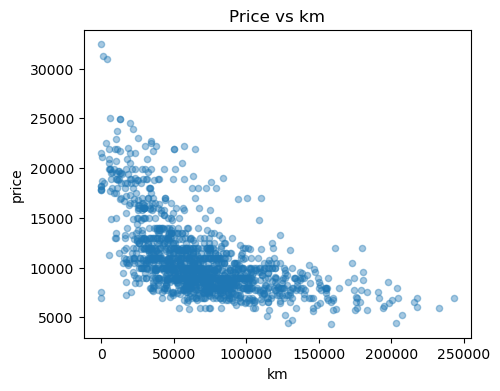

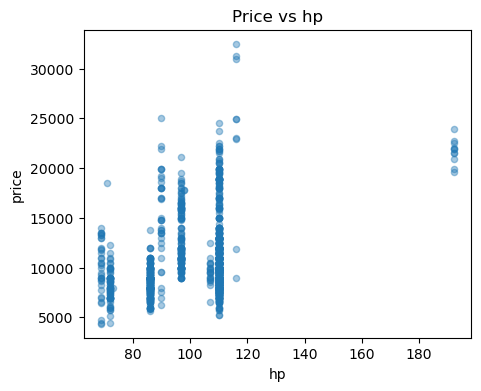

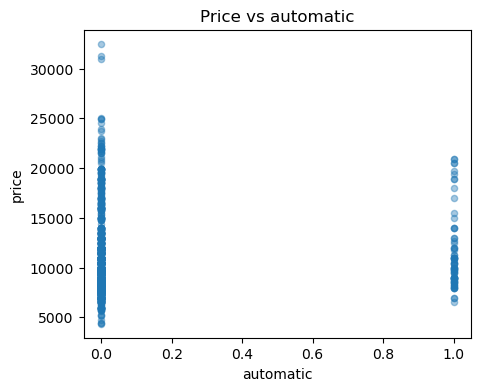

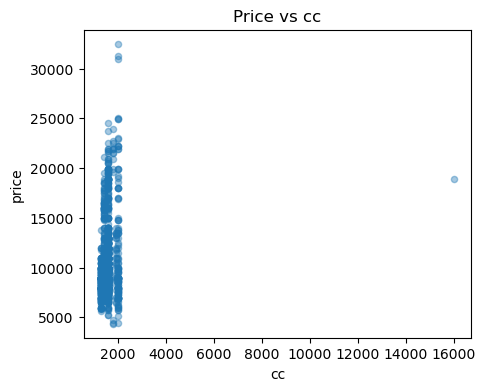

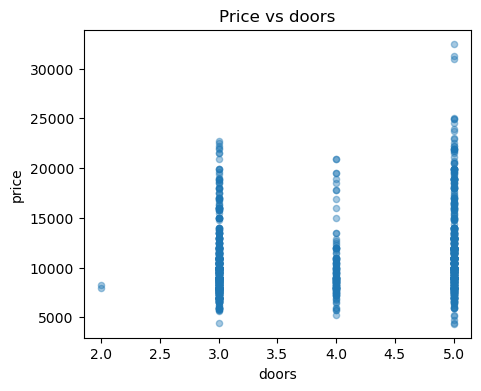

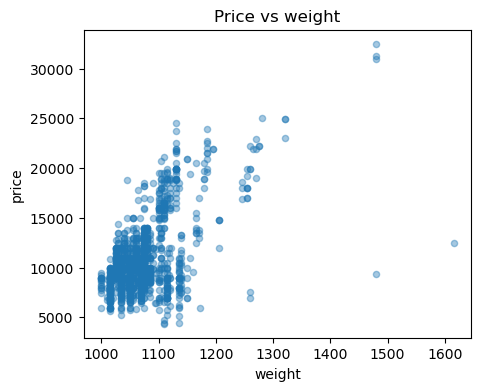

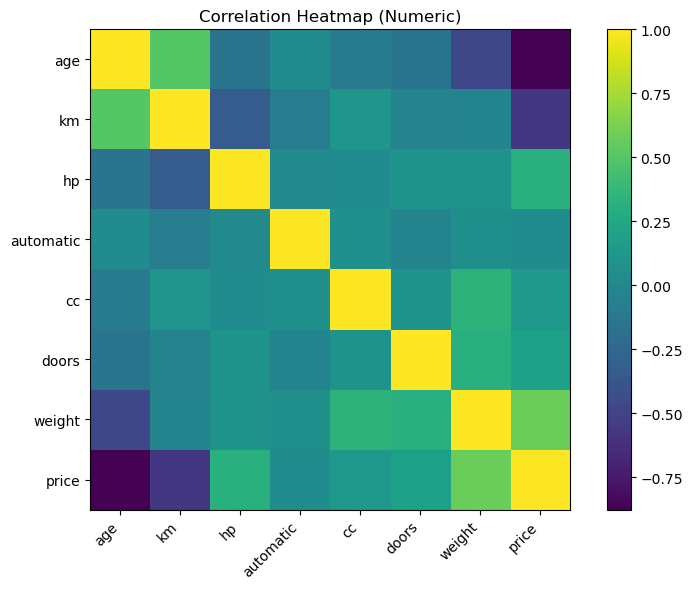

In [10]:
# 2) EDA (quick but informative)
# ===============================
print("Shape after cleaning:", df_work.shape)
print("\nPreview:")
display(df_work.head())

print("\nDescribe (numeric):")
display(df_work.describe().T)

if "fueltype" in df_work.columns:
    print("\nFuel Type counts:")
    display(df_work["fueltype"].value_counts(dropna=False))

# Histograms
num_cols = [c for c in ["age","km","hp","automatic","cc","doors","weight","quarterly_tax","price"] if c in df_work.columns]
df_work[num_cols].hist(figsize=(14,8), bins=20)
plt.suptitle("Histograms of Numeric Features", y=1.02)
plt.show()

# Scatter vs price
for c in [col for col in num_cols if col != "price"]:
    df_work.plot(kind="scatter", x=c, y="price", alpha=0.4, figsize=(5,4))
    plt.title(f"Price vs {c}")
    plt.show()

# Correlation heatmap (numeric)
corr = df_work[num_cols].corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr)), corr.index)
plt.title("Correlation Heatmap (Numeric)")
plt.colorbar()
plt.tight_layout()
plt.show()

In [12]:
# 3) Train/Test Split
# ===============================
TARGET = "price"
FEATURES_BASE = [c for c in df_work.columns if c != TARGET]

X = df_work[FEATURES_BASE].copy()
y = df_work[TARGET].copy()

cat_cols = [c for c in X.columns if X[c].dtype == "object"]
num_cols = [c for c in X.columns if c not in cat_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

In [16]:
# ===============================
# 4) Preprocessing Pipelines (version-safe)
# ===============================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Numeric pipeline
num_pipe = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler()),
])

# Categorical pipeline — handle sklearn version differences:
# - >=1.2 uses 'sparse_output'
# - < 1.2 uses 'sparse'
try:
    cat_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)),
    ])
except TypeError:
    # Fallback for older sklearn
    cat_pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first", sparse=False)),
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

def get_feature_names(fitted_preprocessor, num_cols, cat_cols):
    """
    Return output feature names after the ColumnTransformer is FIT.
    Call this AFTER: fitted_preprocessor.fit(X, y) or inside a fitted Pipeline.
    """
    feature_names = list(num_cols)  # numeric names preserved

    if cat_cols:
        # Access the fitted OneHotEncoder
        try:
            ohe = fitted_preprocessor.named_transformers_["cat"].named_steps["ohe"]
        except AttributeError:
            # If this ColumnTransformer sits inside a Pipeline as step 'prep'
            ohe = fitted_preprocessor["cat"].named_steps["ohe"]

        cat_names = list(ohe.get_feature_names_out(cat_cols))
        feature_names.extend(cat_names)

    return feature_names


In [18]:
# 5) Metrics Helper
# ===============================
def regression_metrics(y_true, y_pred) -> dict:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(1e-8, y_true))) * 100
    return {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE_%": mape}

def display_metrics_table(title: str, metrics_dict: dict):
    dfm = pd.DataFrame(metrics_dict).T
    display(Markdown(f"### {title}"))
    display(dfm.style.format({"R2":"{:.4f}","MAE":"{:.2f}","RMSE":"{:.2f}","MAPE_%":"{:.2f}"}))

In [20]:
# 6) OLS Model (Model 1: All Features)
# ===============================
model_ols = Pipeline(steps=[
    ("prep", preprocessor),
    ("linreg", LinearRegression())
])
model_ols.fit(X_train, y_train)

y_tr_pred = model_ols.predict(X_train)
y_te_pred = model_ols.predict(X_test)

m1_train = regression_metrics(y_train, y_tr_pred)
m1_test  = regression_metrics(y_test,  y_te_pred)
display_metrics_table("Model 1 (OLS, All Features) — Metrics", {"Train": m1_train, "Test": m1_test})

# Extract standardized coefficients (post-scaling)
prep_only = preprocessor.fit(X_train, y_train)
X_train_mat = prep_only.transform(X_train)
feat_names = get_feature_names(preprocessor, num_cols, cat_cols)

lin = LinearRegression().fit(X_train_mat, y_train)
coefs = pd.Series(lin.coef_, index=feat_names).sort_values(key=lambda s: s.abs(), ascending=False)
display(Markdown("### Model 1 — Coefficients (standardized scale)"))
display(coefs.to_frame("coef").head(20))
display(coefs.to_frame("coef").tail(20))

### Model 1 (OLS, All Features) — Metrics

,R2,MAE,RMSE,MAPE_%
Train,0.8703,956.69,1303.34,9.55
Test,0.8349,990.89,1484.27,9.90


### Model 1 — Coefficients (standardized scale)

,coef
age,-2.267295e+03
fueltype_petrol,1.370809e+03
weight,1.316818e+03
km,-6.116544e+02
hp,2.083499e+02
gears,1.093404e+02
fueltype_diesel,-6.854876e+01
doors,-5.746780e+01
automatic,3.439713e+01
cc,-1.416192e+01


,coef
age,-2.267295e+03
fueltype_petrol,1.370809e+03
weight,1.316818e+03
km,-6.116544e+02
hp,2.083499e+02
gears,1.093404e+02
fueltype_diesel,-6.854876e+01
doors,-5.746780e+01
automatic,3.439713e+01
cc,-1.416192e+01


In [22]:
# 7) VIF Analysis
# ===============================
# Add constant for statsmodels, compute VIF on the design matrix (no perfect collinearity due to drop='first')
X_for_vif = sm.add_constant(pd.DataFrame(X_train_mat, columns=feat_names), has_constant='add')
vif_df = pd.DataFrame({
    "feature": ["const"] + feat_names,
    "VIF": [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]
})
display(Markdown("### Variance Inflation Factor (VIF) — Model 1 design matrix"))
display(vif_df.sort_values("VIF", ascending=False).head(20))

# Identify weak features (lowest |coef|) and high VIF features
WEAK_N = max(1, min(5, len(coefs)//6))  # take a few weakest by magnitude
weak_by_coef = list(coefs.abs().sort_values().head(WEAK_N).index)

HIGH_VIF_THRESHOLD = 10.0
high_vif_feats = vif_df.loc[(vif_df["feature"] != "const") & (vif_df["VIF"] > HIGH_VIF_THRESHOLD), "feature"].tolist()

display(Markdown("**Weak features by coefficient magnitude:** " + ", ".join(weak_by_coef) if weak_by_coef else "**Weak features by coefficient:** none"))
display(Markdown("**High-VIF features (>10):** " + (", ".join(high_vif_feats) if high_vif_feats else "none")))

### Variance Inflation Factor (VIF) — Model 1 design matrix

,feature,VIF
0,const,72.496039
10,fueltype_diesel,10.308831
11,fueltype_petrol,8.435396
9,weight,3.880178
3,hp,2.390991
2,km,2.049863
1,age,1.963717
6,doors,1.227924
5,cc,1.194085
4,automatic,1.122540


**Weak features by coefficient magnitude:** cylinders

**High-VIF features (>10):** fueltype_diesel

In [24]:
# 8) Model 2: Just highlight weak features (no removal, explanatory)
# ===============================
display(Markdown("## Model 2 — Highlight Weak Features (no removal)"))
display(Markdown(
    "*Instructors asked to identify weakest predictors and interpret; "
    "we keep the feature set unchanged but flag candidates for removal based on very low coefficient magnitude and/or high VIF.*"
))


## Model 2 — Highlight Weak Features (no removal)

*Instructors asked to identify weakest predictors and interpret; we keep the feature set unchanged but flag candidates for removal based on very low coefficient magnitude and/or high VIF.*

In [26]:
# 9) Model 3: Remove weak features & refit OLS
# ===============================
to_remove = sorted(set(weak_by_coef + high_vif_feats))
display(Markdown("**Features removed in Model 3:** " + (", ".join(to_remove) if to_remove else "none")))
if to_remove:
    # map back to original columns for dropping from X (only cat dummies live after transform; for safety, we re-run with reduced raw cols if possible)
    # Strategy: if the removed feature is a raw numeric feature name, drop it. If it's a dummy "fueltype_x", we will drop whole categorical col from raw X.
    drop_raw = []
    for f in to_remove:
        if f in X.columns:  # numeric raw
            drop_raw.append(f)
        else:
            # dummy like "fueltype_petrol" -> drop the entire 'fueltype' from raw features
            for c in cat_cols:
                if f.startswith(c + "_"):
                    drop_raw.append(c)
                    break
    drop_raw = sorted(set([c for c in drop_raw if c in X.columns]))
    display(Markdown("**Raw columns removed:** " + (", ".join(drop_raw) if drop_raw else "none")))
else:
    drop_raw = []

FEATURES_M3 = [c for c in FEATURES_BASE if c not in drop_raw]
X3_train = X_train[FEATURES_M3].copy()
X3_test  = X_test[FEATURES_M3].copy()

num3 = [c for c in FEATURES_M3 if c in num_cols]
cat3 = [c for c in FEATURES_M3 if c in cat_cols]

pre3 = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num3),
        ("cat", cat_pipe, cat3)
    ],
    remainder="drop"
)

model3 = Pipeline(steps=[("prep", pre3), ("linreg", LinearRegression())])
model3.fit(X3_train, y_train)
y3_tr = model3.predict(X3_train)
y3_te = model3.predict(X3_test)

m3_train = regression_metrics(y_train, y3_tr)
m3_test  = regression_metrics(y_test, y3_te)

display_metrics_table("Model 3 (OLS after removing weak/high-VIF) — Metrics", {"Train": m3_train, "Test": m3_test})


**Features removed in Model 3:** cylinders, fueltype_diesel

**Raw columns removed:** cylinders, fueltype

### Model 3 (OLS after removing weak/high-VIF) — Metrics

,R2,MAE,RMSE,MAPE_%
Train,0.8659,985.66,1325.08,9.86
Test,0.8523,997.00,1403.61,10.01


In [28]:
# 10) Regularization: RidgeCV & LassoCV
# ===============================
alphas = np.logspace(-3, 3, 30)

# Ridge
ridge = Pipeline(steps=[("prep", preprocessor), ("ridge", RidgeCV(alphas=alphas, store_cv_values=False))])
ridge.fit(X_train, y_train)
y_tr_r = ridge.predict(X_train)
y_te_r = ridge.predict(X_test)
mR_train = regression_metrics(y_train, y_tr_r)
mR_test  = regression_metrics(y_test,  y_te_r)

# Lasso
lasso = Pipeline(steps=[("prep", preprocessor), ("lasso", LassoCV(alphas=None, cv=5, random_state=RANDOM_STATE, max_iter=10000))])
lasso.fit(X_train, y_train)
y_tr_l = lasso.predict(X_train)
y_te_l = lasso.predict(X_test)
mL_train = regression_metrics(y_train, y_tr_l)
mL_test  = regression_metrics(y_test,  y_te_l)

# Non-zero count for Lasso
prep_L = preprocessor.fit(X_train, y_train)
Xmat_L = prep_L.transform(X_train)
lasso_raw = LassoCV(alphas=None, cv=5, random_state=RANDOM_STATE, max_iter=10000).fit(Xmat_L, y_train)
nnz = int(np.sum(lasso_raw.coef_ != 0))

display(Markdown(f"**Ridge best alpha:** {ridge.named_steps['ridge'].alpha_:.6f}"))
display(Markdown(f"**Lasso chosen alpha:** {lasso.named_steps['lasso'].alpha_:.6f}"))
display(Markdown(f"**Lasso non-zero coefficients:** {nnz}"))

display_metrics_table("Ridge — Metrics", {"Train": mR_train, "Test": mR_test})
display_metrics_table("Lasso — Metrics", {"Train": mL_train, "Test": mL_test})


**Ridge best alpha:** 148.735211

**Lasso chosen alpha:** 59.544728

**Lasso non-zero coefficients:** 6

### Ridge — Metrics

,R2,MAE,RMSE,MAPE_%
Train,0.8617,989.28,1345.45,9.75
Test,0.8445,1001.09,1440.40,9.88


### Lasso — Metrics

,R2,MAE,RMSE,MAPE_%
Train,0.8646,984.59,1331.59,9.80
Test,0.8522,994.06,1404.53,9.89


In [30]:
# 11) Consolidated Comparison
# ===============================
summary = pd.DataFrame({
    "Model": ["OLS (All)", "OLS (Drop Weak/VIF)", "Ridge", "Lasso"],
    "R2_Test": [m1_test["R2"], m3_test["R2"], mR_test["R2"], mL_test["R2"]],
    "RMSE_Test": [m1_test["RMSE"], m3_test["RMSE"], mR_test["RMSE"], mL_test["RMSE"]],
    "MAE_Test": [m1_test["MAE"], m3_test["MAE"], mR_test["MAE"], mL_test["MAE"]],
    "MAPE%_Test": [m1_test["MAPE_%"], m3_test["MAPE_%"], mR_test["MAPE_%"], mL_test["MAPE_%"]],
})
display(Markdown("## Model Comparison (Test Set)"))
display(summary.sort_values("R2_Test", ascending=False).style.format({
    "R2_Test":"{:.4f}", "RMSE_Test":"{:.2f}", "MAE_Test":"{:.2f}", "MAPE%_Test":"{:.2f}"
}))


## Model Comparison (Test Set)

,Model,R2_Test,RMSE_Test,MAE_Test,MAPE%_Test
1,OLS (Drop Weak/VIF),0.8523,1403.61,997.00,10.01
3,Lasso,0.8522,1404.53,994.06,9.89
2,Ridge,0.8445,1440.40,1001.09,9.88
0,OLS (All),0.8349,1484.27,990.89,9.90


In [32]:
# 12) EXPLANATIONS (As required by guide)
# ===============================

# 12a) Detailed interpretation of coefficients (top +/-)
TOPK = min(8, len(coefs))
top_pos = coefs.sort_values(ascending=False).head(TOPK)
top_neg = coefs.sort_values(ascending=True).head(TOPK)

interpret_lines = []
interpret_lines.append("### Detailed Interpretation of Model Coefficients (Model 1 — standardized)")
interpret_lines.append(
    "Coefficients are on a standardized scale (after imputation & scaling). "
    "Interpretation: a +ve coefficient means price increases as the feature rises (holding others constant); "
    "a -ve coefficient means price decreases."
)
interpret_lines.append("**Top positive coefficients** suggest features that increase price the most; "
                       "**top negative coefficients** decrease price the most.")
interpret_lines.append("\n**Top positive:**")
for f, v in top_pos.items():
    interpret_lines.append(f"- `{f}`: +{v:.3f} — one SD increase in `{f}` is associated with about {v:.3f} SD increase in price.")
interpret_lines.append("\n**Top negative:**")
for f, v in top_neg.items():
    interpret_lines.append(f"- `{f}`: {v:.3f} — one SD increase in `{f}` is associated with about {v:.3f} SD decrease in price.")
display(Markdown("\n".join(interpret_lines)))

# 12b) Discussion of evaluation metrics
metric_md = f"""
### Discussion of Model Evaluation Metrics

We report **R²**, **MAE**, **RMSE**, and **MAPE** on train/test:

- **R²** quantifies explained variance (closer to 1 is better).  
- **MAE** is average absolute error in € (easy to interpret).  
- **RMSE** penalizes larger errors more than MAE (sensitive to outliers).  
- **MAPE** expresses average error as a percentage of actual price.

**Model 1 (All features):** Test R² = {m1_test['R2']:.4f}, MAE ≈ €{m1_test['MAE']:.0f}, RMSE ≈ €{m1_test['RMSE']:.0f}, MAPE ≈ {m1_test['MAPE_%']:.2f}%.  
**Model 3 (After removing weak/high-VIF):** Test R² = {m3_test['R2']:.4f}, MAE ≈ €{m3_test['MAE']:.0f}, RMSE ≈ €{m3_test['RMSE']:.0f}, MAPE ≈ {m3_test['MAPE_%']:.2f}%.

**Regularized models:**
- **Ridge** (best α = {ridge.named_steps['ridge'].alpha_:.6f}) tends to stabilize coefficients under multicollinearity; Test R² = {mR_test['R2']:.4f}.
- **Lasso** (α = {lasso.named_steps['lasso'].alpha_:.6f}, non-zero={nnz}) can drop weak features; Test R² = {mL_test['R2']:.4f}.

**Takeaway:** Prefer the model with the best generalization (highest Test R², lowest RMSE/MAE/MAPE). Ridge often helps when predictors are correlated; Lasso helps simplify by feature selection.
"""
display(Markdown(metric_md))

# 12c) Assumptions of Linear Regression & Implications
assumptions = """
### Assumptions of Linear Regression & Their Implications

1. **Linearity**: Relationship between predictors and price is linear.  
   *Check:* residuals vs predicted plot should show no curved patterns.  
2. **Independence of Errors**: Observations are independent.  
   *Risk:* time/cluster effects can violate this.  
3. **Homoscedasticity**: Constant variance of residuals.  
   *Violation:* funnel-shaped residuals; use robust SE, transform target, or model variance.  
4. **Normality of Errors**: Residuals roughly normal.  
   *Check:* histogram / QQ-plot.  
5. **No Perfect Multicollinearity**: Predictors not linear combinations of others.  
   *Check:* VIF.

**Implications:** If assumptions are violated, coefficient estimates and inference may be biased or inefficient; prediction intervals may be unreliable. Remedies include transformations, adding interaction/ polynomial terms, using robust methods, or regularization.
"""
display(Markdown(assumptions))

# 12d) Multicollinearity: how we addressed it (based on VIF)
mc_text = f"""
### Multicollinearity & VIF — Detection and Mitigation

- We computed **VIF** on the post-processed design matrix (with `drop='first'` to avoid dummy trap).
- **Rule of thumb:** VIF > 10 indicates problematic multicollinearity.

**In this run:**
- High-VIF features detected: {", ".join(high_vif_feats) if high_vif_feats else "none"}.
- Weak-by-coefficient features: {", ".join(weak_by_coef) if weak_by_coef else "none"}.

**Mitigation applied:**
1) **Model 3** removes weak/high-VIF features and refits OLS.  
2) **Ridge** shrinks correlated coefficients (reduces variance).  
3) **Lasso** performs feature selection, zeroing out very weak predictors.

If many dummies from a single categorical drive VIF, consider collapsing rare levels or using **target encoding** (with care) / **PCA** on numeric blocks.
"""
display(Markdown(mc_text))

### Detailed Interpretation of Model Coefficients (Model 1 — standardized)
Coefficients are on a standardized scale (after imputation & scaling). Interpretation: a +ve coefficient means price increases as the feature rises (holding others constant); a -ve coefficient means price decreases.
**Top positive coefficients** suggest features that increase price the most; **top negative coefficients** decrease price the most.

**Top positive:**
- `fueltype_petrol`: +1370.809 — one SD increase in `fueltype_petrol` is associated with about 1370.809 SD increase in price.
- `weight`: +1316.818 — one SD increase in `weight` is associated with about 1316.818 SD increase in price.
- `hp`: +208.350 — one SD increase in `hp` is associated with about 208.350 SD increase in price.
- `gears`: +109.340 — one SD increase in `gears` is associated with about 109.340 SD increase in price.
- `automatic`: +34.397 — one SD increase in `automatic` is associated with about 34.397 SD increase in price.
- `cylinders`: +0.000 — one SD increase in `cylinders` is associated with about 0.000 SD increase in price.
- `cc`: +-14.162 — one SD increase in `cc` is associated with about -14.162 SD increase in price.
- `doors`: +-57.468 — one SD increase in `doors` is associated with about -57.468 SD increase in price.

**Top negative:**
- `age`: -2267.295 — one SD increase in `age` is associated with about -2267.295 SD decrease in price.
- `km`: -611.654 — one SD increase in `km` is associated with about -611.654 SD decrease in price.
- `fueltype_diesel`: -68.549 — one SD increase in `fueltype_diesel` is associated with about -68.549 SD decrease in price.
- `doors`: -57.468 — one SD increase in `doors` is associated with about -57.468 SD decrease in price.
- `cc`: -14.162 — one SD increase in `cc` is associated with about -14.162 SD decrease in price.
- `cylinders`: 0.000 — one SD increase in `cylinders` is associated with about 0.000 SD decrease in price.
- `automatic`: 34.397 — one SD increase in `automatic` is associated with about 34.397 SD decrease in price.
- `gears`: 109.340 — one SD increase in `gears` is associated with about 109.340 SD decrease in price.


### Discussion of Model Evaluation Metrics

We report **R²**, **MAE**, **RMSE**, and **MAPE** on train/test:

- **R²** quantifies explained variance (closer to 1 is better).  
- **MAE** is average absolute error in € (easy to interpret).  
- **RMSE** penalizes larger errors more than MAE (sensitive to outliers).  
- **MAPE** expresses average error as a percentage of actual price.

**Model 1 (All features):** Test R² = 0.8349, MAE ≈ €991, RMSE ≈ €1484, MAPE ≈ 9.90%.  
**Model 3 (After removing weak/high-VIF):** Test R² = 0.8523, MAE ≈ €997, RMSE ≈ €1404, MAPE ≈ 10.01%.

**Regularized models:**
- **Ridge** (best α = 148.735211) tends to stabilize coefficients under multicollinearity; Test R² = 0.8445.
- **Lasso** (α = 59.544728, non-zero=6) can drop weak features; Test R² = 0.8522.

**Takeaway:** Prefer the model with the best generalization (highest Test R², lowest RMSE/MAE/MAPE). Ridge often helps when predictors are correlated; Lasso helps simplify by feature selection.



### Assumptions of Linear Regression & Their Implications

1. **Linearity**: Relationship between predictors and price is linear.  
   *Check:* residuals vs predicted plot should show no curved patterns.  
2. **Independence of Errors**: Observations are independent.  
   *Risk:* time/cluster effects can violate this.  
3. **Homoscedasticity**: Constant variance of residuals.  
   *Violation:* funnel-shaped residuals; use robust SE, transform target, or model variance.  
4. **Normality of Errors**: Residuals roughly normal.  
   *Check:* histogram / QQ-plot.  
5. **No Perfect Multicollinearity**: Predictors not linear combinations of others.  
   *Check:* VIF.

**Implications:** If assumptions are violated, coefficient estimates and inference may be biased or inefficient; prediction intervals may be unreliable. Remedies include transformations, adding interaction/ polynomial terms, using robust methods, or regularization.



### Multicollinearity & VIF — Detection and Mitigation

- We computed **VIF** on the post-processed design matrix (with `drop='first'` to avoid dummy trap).
- **Rule of thumb:** VIF > 10 indicates problematic multicollinearity.

**In this run:**
- High-VIF features detected: fueltype_diesel.
- Weak-by-coefficient features: cylinders.

**Mitigation applied:**
1) **Model 3** removes weak/high-VIF features and refits OLS.  
2) **Ridge** shrinks correlated coefficients (reduces variance).  
3) **Lasso** performs feature selection, zeroing out very weak predictors.

If many dummies from a single categorical drive VIF, consider collapsing rare levels or using **target encoding** (with care) / **PCA** on numeric blocks.


## Interview Questions

**Q1. What is Normalization & Standardization and how is it helpful?**  
- **Normalization**: Scales values into a fixed range, usually [0, 1]. Example: converting Age from 18–60 into 0–1.  
- **Standardization**: Transforms data to have **mean = 0 and standard deviation = 1**. Example: z-score scaling.  

**Why helpful?**  
- Ensures all features are on a similar scale (important for regression, distance-based algorithms, and regularization methods like Ridge/Lasso).  
- Makes coefficients more interpretable and avoids features with large ranges dominating the model.  

---

**Q2. What techniques can be used to address multicollinearity in multiple linear regression?**  
1. **Variance Inflation Factor (VIF)** → detect multicollinearity (VIF > 10 = problem).  
2. **Remove redundant variables** → drop one of the highly correlated predictors.  
3. **Combine features** → e.g., average or principal component (PCA).  
4. **Regularization**:  
   - **Ridge Regression** shrinks correlated coefficients.  
   - **Lasso Regression** can eliminate weak, redundant predictors.  
